In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
sys.path.append('../scripts/')
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import mask_var as mvar
import rasterio
from rasterio.plot import show 
from rasterio.plot import plotting_extent
from osdatahub import NGD
from dotenv import load_dotenv

### Create Urban Mask

In [4]:
# Set API key, details from https://github.com/OrdnanceSurvey/osdatahub
load_dotenv()
key_os = os.environ['KEY']

In [5]:
ngd_collections = NGD.get_collections()
for collection in ngd_collections['collections']:
    print(f' - {collection["title"]} ({collection["id"]})')

 - Building v1 (bld-fts-building-1)
 - Building Line v1 (bld-fts-buildingline-1)
 - Building Part v1 (bld-fts-buildingpart-1)
 - Named Area v1 (gnm-fts-namedarea-1)
 - Named Point v1 (gnm-fts-namedpoint-1)
 - Land v1 (lnd-fts-land-1)
 - Landform v1 (lnd-fts-landform-1)
 - Landform Line v1 (lnd-fts-landformline-1)
 - Landform Point v1 (lnd-fts-landformpoint-1)
 - Land Point v1 (lnd-fts-landpoint-1)
 - Site v1 (lus-fts-site-1)
 - Site Access Location v1 (lus-fts-siteaccesslocation-1)
 - Site Routing Point v1 (lus-fts-siteroutingpoint-1)
 - Compound Structure v1 (str-fts-compoundstructure-1)
 - Structure v1 (str-fts-structure-1)
 - Structure Line v1 (str-fts-structureline-1)
 - Structure Point v1 (str-fts-structurepoint-1)
 - Cartographic Rail Detail v1 (trn-fts-cartographicraildetail-1)
 - Rail v1 (trn-fts-rail-1)
 - Road Line v1 (trn-fts-roadline-1)
 - Road Track Or Path v1 (trn-fts-roadtrackorpath-1)
 - Connecting Link v1 (trn-ntwk-connectinglink-1)
 - Connecting Node v1 (trn-ntwk-conn

In [9]:
# define layer for bbox extent & OS-API collection
lyr = rasterio.open("../content/tifs/1k_tifs/SK1868.tif")

# os collections for urban mask
collections = {'buildings' : 'bld-fts-buildingpart-1',
               'sites' : 'lus-fts-site-1', 
               'railways' : 'trn-fts-rail-1', 
               'land' : 'lnd-fts-land-1',
               'water' : 'wtr-fts-waterpoint-1',
               'road' : 'trn-fts-roadline-1',
               'track' : 'trn-fts-roadtrackorpath-1',
               'waterlink' : 'wtr-ntwk-waterlink-1',
               'waterlinkset' : 'wtr-ntwk-waterlinkset-1'}

dict_os_layers = {}
gdf = gpd.GeoDataFrame()

# API variables
for key, value in collections.items():
    ngd = NGD(key_os, value)
    ngd_ = "ngd_" + key
    dict_os_layers[ngd_] = ngd.query(extent=mvar.bb(lyr), crs="EPSG:27700", max_results=1000000000)
    if dict_os_layers[ngd_]['numberReturned'] > 0:
        # add to dict
        dict_os_layers.update(dict_os_layers[ngd_])
        d =  gpd.GeoDataFrame.from_features((dict_os_layers[ngd_]), crs="EPSG:27700")
        gdf = pd.concat([gdf, d])
        print(ngd_ + " query contains the following number of features:" + str(dict_os_layers[ngd_]['numberReturned']))
    else:
        print(key + " query is empty!")

ngd_buildings query contains the following number of features:18
ngd_sites query contains the following number of features:1
railways query is empty!
ngd_land query contains the following number of features:129
ngd_water query contains the following number of features:1
road query is empty!
ngd_track query contains the following number of features:34
waterlink query is empty!
waterlinkset query is empty!


In [10]:
# create urban mask
mask = mvar.urban_mask(gdf)

(Text(0.5, 159.0, 'Eastings'), Text(185.71536269953575, 0.5, 'Northings'))

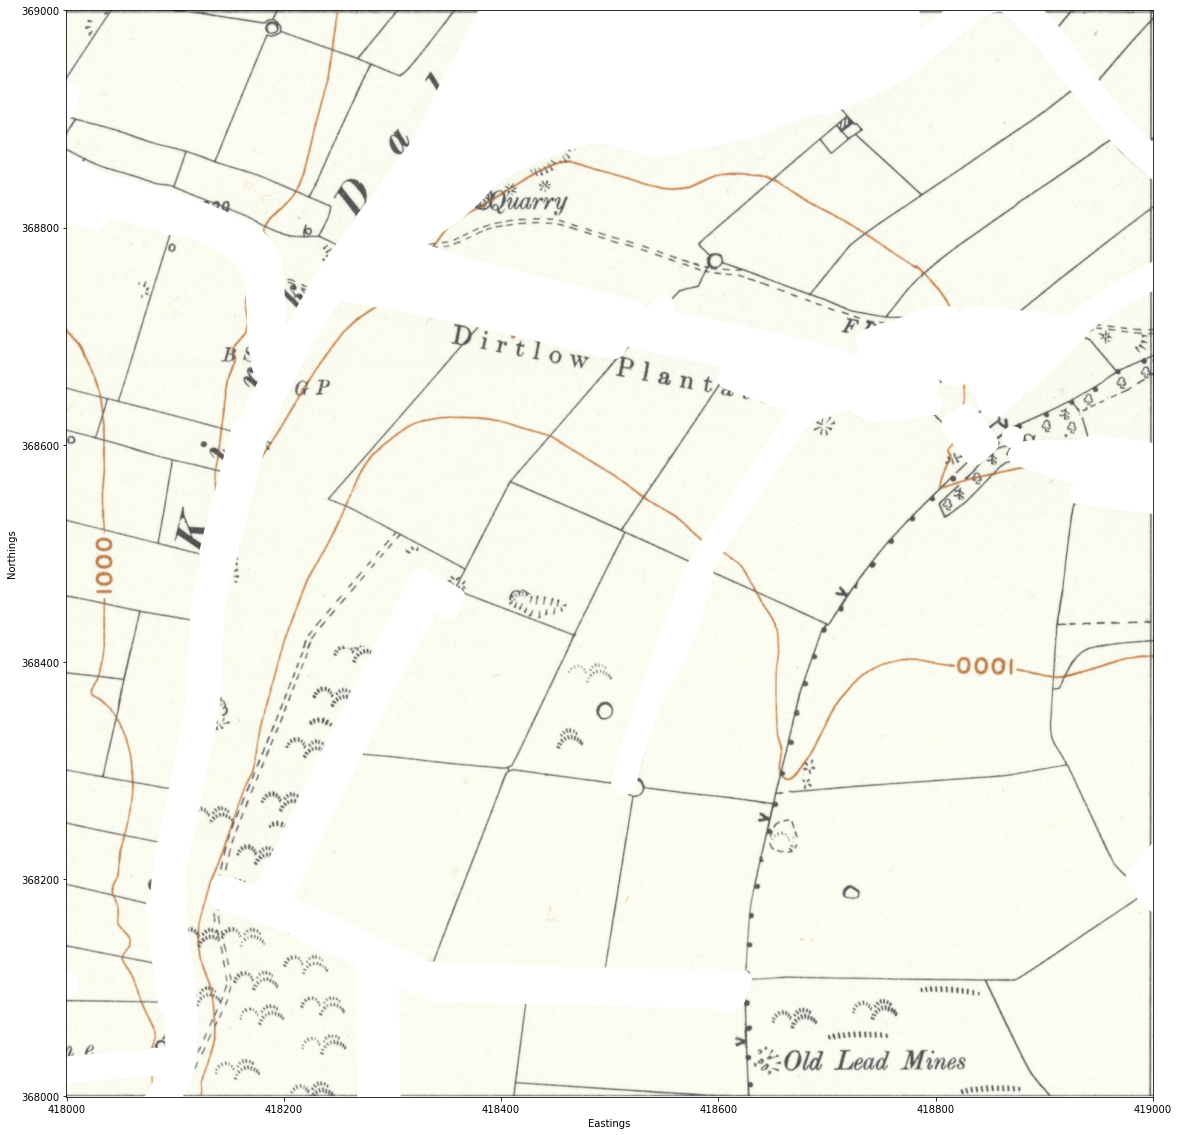

In [11]:
ax = mask.plot(color="white", alpha=1, figsize=(20, 20))
show(lyr, ax=ax, with_bounds=True)
ax.set_xlabel("Eastings"), ax.set_ylabel("Northings")
#ax.set_xlim(417000, xmax=419000)
#ax.set_ylim(367000, ymax=369000)

#### Output as raster for map-reader.ipynb

In [9]:
# add a column for raster value labels
mask['theme'] = 1
mask.head()

,geometry,theme
0,"MULTIPOLYGON (((403178.053 370995.085, 403177....",1


In [10]:
# raster calcs
print(lyr.width)
print(lyr.height)
print(lyr.meta)

7448
7448
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 7448, 'height': 7448, 'count': 3, 'crs': CRS.from_wkt('PROJCS["OSGB_1936_British_National_Grid",GEOGCS["GCS_OSGB_1936",DATUM["D_OSGB_1936",SPHEROID["Airy_1830",6377563.396,299.3249646]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.9996012717],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(0.6713215494092012, 0.0, 415000.0005999999,
       0.0, -0.6713209989263084, 369999.9979000004)}


In [11]:
#ex_raster = mvar.convert_shp_mask_to_raster(df_shp=mask,
                                           plot_raster=False,
                                           save_raster=True,
                                           verbose=1)

IndentationError: unexpected indent (2650991057.py, line 2)

In [ ]:
# save as a new file 
out_file_path = r"../content/ngd_boundaries/mask.shp"
mask.to_file(out_file_path)